In [1]:
import io
import pandas as pd
with open('../../preprocessing/data/caida/20251001.as-org2info.txt', 'r', newline='', encoding='utf-8') as input_file:
    lines = input_file.readlines()   
    # Buffers initialisieren
    aut_lines = []
    org_lines = []
    mode = None
    total_lines = len(lines)
    aut_count = 0
    org_count = 0 

    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith("# format:aut"):
            mode = "aut"
            continue
        elif line.startswith("# format:org_id"):
            mode = "org"
            continue
        elif line.startswith("#") or not line:
            # Andere Kommentar- oder Leerzeilen überspringen
            continue      
        if mode == "aut":
            aut_lines.append(line)
            aut_count += 1
        elif mode == "org":
            org_lines.append(line)
            org_count += 1
    # StringIO-Objekte aus den gesammelten Zeilen bauen
    aut_buffer = io.StringIO("\n".join(aut_lines))
    org_buffer = io.StringIO("\n".join(org_lines))
    # DataFrames einlesen
    aut_df = pd.read_csv(aut_buffer, sep="|",
                        names=["aut", "changed", "aut_name", "org_id", "opaque_id", "source"], usecols=["aut", "org_id", "source", "changed", "aut_name"])
    org_df = pd.read_csv(org_buffer, sep="|",
                        names=["org_id", "changed", "org_name", "country", "source"], usecols=["org_id", "org_name", "country"])

    # Join the DataFrames
    joined_df = pd.merge(aut_df, org_df, on="org_id", how="left")
SEP_TOKEN = '</s>'
joined_df['text'] = joined_df['aut_name'].astype(str) + SEP_TOKEN + joined_df['org_name'].astype(str)
joined_df.head()

,aut,changed,aut_name,org_id,source,org_name,country,text
0,1,20240618.0,LVLT-1,LPL-141-ARIN,ARIN,"Level 3 Parent, LLC",US,"LVLT-1</s>Level 3 Parent, LLC"
1,2,20231108.0,UDEL-DCN,UNIVER-19-Z-ARIN,ARIN,University of Delaware,US,UDEL-DCN</s>University of Delaware
2,3,20100927.0,MIT-GATEWAYS,MIT-2-ARIN,ARIN,Massachusetts Institute of Technology,US,MIT-GATEWAYS</s>Massachusetts Institute of Tec...
3,4,20230929.0,ISI-AS,USC-32-Z-ARIN,ARIN,University of Southern California,US,ISI-AS</s>University of Southern California
4,5,20200723.0,SYMBOLICS,WGL-117-ARIN,ARIN,WFA Group LLC,US,SYMBOLICS</s>WFA Group LLC


In [2]:
as_rank_df = pd.read_csv('../../preprocessing/data/asrank/as_rank_df.csv')
as_rank_df.head()
as_rank_df['rank'].fillna(as_rank_df['rank'].median(), inplace=True)
as_rank_df['asnDegree_total'].fillna(as_rank_df['asnDegree_total'].median(), inplace=True)
as_rank_df['asnDegree_customer'].fillna(as_rank_df['asnDegree_customer'].median(), inplace=True)
as_rank_df['asnDegree_peer'].fillna(as_rank_df['asnDegree_peer'].median(), inplace=True)
as_rank_df['asnDegree_provider'].fillna(as_rank_df['asnDegree_provider'].median(), inplace=True)
as_rank_df['cone_numberAsns'].fillna(as_rank_df['cone_numberAsns'].median(), inplace=True)
as_rank_df['cone_numberPrefixes'].fillna(as_rank_df['cone_numberPrefixes'].median(), inplace=True)
as_rank_df['cone_numberAddresses'].fillna(as_rank_df['cone_numberAddresses'].median(), inplace=True)

/tmp/ipykernel_1272050/958748441.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  as_rank_df['rank'].fillna(as_rank_df['rank'].median(), inplace=True)
/tmp/ipykernel_1272050/958748441.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [3]:
ipinfo_df = pd.read_csv('../../preprocessing/data/ipinfo_domains/ipinfo_domains.csv')
ipinfo_df['domains'].fillna(0, inplace=True)

ipinfo_df.head()

/tmp/ipykernel_1272050/3215654155.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ipinfo_df['domains'].fillna(0, inplace=True)


,ASN,domains
0,16509,139276485
1,13335,63477595
2,52925,32915972
3,396982,24543491
4,47846,17833760


In [4]:
bgp_df = pd.read_csv('../../preprocessing/data/bgp/as_metrics_with_rpki.csv')

/tmp/ipykernel_1272050/1067223661.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  bgp_df = pd.read_csv('../../preprocessing/data/bgp/as_metrics_with_rpki.csv')


In [5]:
ch_df = pd.read_csv('../../preprocessing/data/clickhouse/asn_geolocation_stats.csv')

In [6]:
import os, math, warnings, joblib
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Optional, Tuple

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack

from xgboost import XGBClassifier

import torch
import torch.nn.functional as F
def build_numeric_frame(df: pd.DataFrame, verbose=True) -> Tuple[pd.DataFrame, List[str]]:
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = []
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km",
                    "visibility_path", "visibility_origin", "country_entropy_norm", "rpki_valid_share"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2", "ratio_customer_provider", "ratio_peer_provider", "ratio_peer_total",
        "frac_customer_total", "prefixes_per_asn", "addresses_per_prefix", "addresses_per_asn",
        "seen_peers_path", "seen_peers_origin", "total_peers",
        "origin_occurrences", "path_occurrences", "endprox_mean",  "nonterminal_rate",
        "centrality_mean", "country_entropy_bits", "rpki_valid", "rpki_invalid_as", "rpki_invalid_length",
        "rpki_not_found", "rpki_total"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p (var_km2 erst sqrt)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")

    X = X.replace([np.inf, -np.inf], np.nan)
    return X, cat_cols

class DualTextFeatures:
    """
    Statt 'Late Fusion' geben wir einfach ALLE Wahrscheinlichkeiten (SVM + HF)
    roh zurück. XGBoost (Early Fusion) sucht sich dann die besten aus.
    """
    def __init__(
        self,
        tokenizer,
        hf_model,
        batch_size: int = 64,
        max_length: int = 256,
        tfidf_ngram_range: tuple = (2,7),
        tfidf_min_df: int = 2,
        temp_svm: float | None = None,
        temp_xlm: float | None = None,
    ):
        self.tokenizer = tokenizer
        self.hf_model = hf_model
        self.batch_size = batch_size
        self.max_length = max_length
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.temp_svm = temp_svm
        self.temp_xlm = temp_xlm

        self.tfidf_org_ = None
        self.tfidf_aut_ = None
        self.svm_cal_ = None
        self.label_list_ = None
        self._hf_colpos_cache_ = None

    # ... (Hier deine Hilfsfunktionen _norm und _compute_hf_colpos beibehalten) ...
    # Kopiere _norm und _compute_hf_colpos aus deinem alten Code hier rein
    # oder lass sie, wenn sie extern definiert sind.
    
    @staticmethod
    def _norm(x):
        # ... (wie vorher) ...
        if isinstance(x, (int, np.integer)): return int(x)
        try: return int(x)
        except: return str(x)

    def _compute_hf_colpos(self):
        # ... (Exakt wie in deinem Code oben, keine Änderung nötig) ...
        if self._hf_colpos_cache_ is not None: return self._hf_colpos_cache_
        cfg = getattr(self.hf_model, "config", None)
        # ... (restlicher Code von _compute_hf_colpos) ...
        # (Platzhalter zur Übersichtlichkeit - kopiere den Block 1:1)
        # Am Ende steht da:
        colpos = [int(i) for i in range(len(self.label_list_))] # Fallback
        # Echte Logik von oben nutzen!
        return colpos

    def _hf_proba(self, texts_hf: list[str]) -> np.ndarray:
        # ... (Exakt wie in deinem Code oben) ...
        # WICHTIG: Nutze deine Original-Implementierung von oben!
        self.hf_model.eval()
        tok = self.tokenizer
        probs_all = []
        with torch.no_grad():
            for i in range(0, len(texts_hf), self.batch_size):
                batch = texts_hf[i:i+self.batch_size]
                enc = tok(batch, truncation=True, max_length=self.max_length, padding=True, return_tensors="pt")
                enc = {k: v.to(self.hf_model.device) for k, v in enc.items()}
                logits = self.hf_model(**enc).logits
                if self.temp_xlm: logits /= self.temp_xlm
                probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
                probs_all.append(probs)
        P = np.vstack(probs_all) if probs_all else np.zeros((0, len(self.label_list_)))
        # colpos Logik hier anwenden, falls nötig, oder Label-Liste beim Fit fixieren
        return P 

    def _svm_fit(self, texts_org: list[str], texts_aut: list[str], y: np.ndarray):
        # ... (Exakt wie oben) ...
        self.tfidf_org_ = TfidfVectorizer(analyzer="char", ngram_range=self.tfidf_ngram_range, min_df=self.tfidf_min_df, sublinear_tf=True)
        self.tfidf_aut_ = TfidfVectorizer(analyzer="char", ngram_range=self.tfidf_ngram_range, min_df=self.tfidf_min_df, sublinear_tf=True)
        X_org = self.tfidf_org_.fit_transform(texts_org)
        X_aut = self.tfidf_aut_.fit_transform(texts_aut)
        X = hstack([X_org, X_aut])
        base = LinearSVC(C=0.35, class_weight="balanced")
        self.svm_cal_ = CalibratedClassifierCV(base, method="sigmoid", cv=3)
        self.svm_cal_.fit(X, y)
        self.label_list_ = list(self.svm_cal_.classes_)

    def _svm_proba(self, texts_org: list[str], texts_aut: list[str]) -> np.ndarray:
        # ... (Exakt wie oben) ...
        X_org = self.tfidf_org_.transform(texts_org)
        X_aut = self.tfidf_aut_.transform(texts_aut)
        X = hstack([X_org, X_aut])
        return self.svm_cal_.predict_proba(X)

    # ---- NEUE API ----
    def fit(self, texts_hf, texts_org, texts_aut, y):
        # Wir fitten NUR noch die SVM.
        # Keine K-Fold Schleife mehr nötig, da wir keine Gewichte berechnen!
        self._svm_fit(texts_org, texts_aut, y)
        
        # Für HF müssen wir nur sicherstellen, dass die Spaltenordnung passt
        # Das passiert dynamisch in predict via _compute_hf_colpos oder wir vertrauen drauf.
        # Um sicher zu sein, rufen wir einmal _compute_hf_colpos auf, wenn HF da ist.
        try:
            self._compute_hf_colpos() 
        except:
            pass # Fallback oder Fehlerhandling
        return self

    def predict_proba(self, texts_hf, texts_org, texts_aut) -> np.ndarray:
        # 1. SVM Probas
        P_svm = self._svm_proba(texts_org, texts_aut)
        # 2. HF Probas
        P_hf  = self._hf_proba(texts_hf)
        
        # NEU: Wir geben BEIDES zurück (nebeneinander)
        # Shape ist dann (N, 2 * Klassenanzahl)
        return np.hstack([P_svm, P_hf])

class TempScaler:
    def __init__(self): self.t = torch.nn.Parameter(torch.zeros(1))  # Log-Temp = 0 -> T=1
    def fit(self, probs: np.ndarray, y: np.ndarray, max_iter: int = 200):
        eps = 1e-12
        z = torch.tensor(np.log(np.clip(probs, eps, 1-eps)), dtype=torch.float32)
        y_t = torch.tensor(y, dtype=torch.long)
        opt = torch.optim.LBFGS([self.t], lr=0.5, max_iter=max_iter)

        def closure():
            opt.zero_grad()
            loss = torch.nn.CrossEntropyLoss()(z / torch.exp(self.t), y_t)
            loss.backward()
            return loss
        opt.step(closure)

    def transform_proba(self, probs: np.ndarray) -> np.ndarray:
        eps = 1e-12
        z = torch.tensor(np.log(np.clip(probs, eps, 1-eps)), dtype=torch.float32)
        z = z / torch.exp(self.t).detach()
        p = F.softmax(z, dim=1).numpy()
        return p

    
@dataclass
class FusionModel:
    ens_full: object           # PerClassWeightedLateFusion / DualTextFeatures
    pre_num: object            # ColumnTransformer
    xgb: XGBClassifier
    label_names: Optional[List[str]] = None
    temp_scaler: Optional[object] = None
    feature_names_cache: Optional[List[str]] = None

    def _feature_names(self, Xnum_pre: np.ndarray, P_text: np.ndarray) -> List[str]:
        # Falls schon gecached, nimm den Cache
        if self.feature_names_cache is not None:
             # Kurzer Check, ob die Länge noch passt (falls Cache alt ist)
            if len(self.feature_names_cache) == (Xnum_pre.shape[1] + P_text.shape[1]):
                return self.feature_names_cache
            else:
                self.feature_names_cache = None # Cache verwerfen

        # 1. Numerische Namen holen
        if hasattr(self.pre_num, 'get_feature_names_out'):
            num_names = list(self.pre_num.get_feature_names_out())
        else:
            num_names = [f"num_{i}" for i in range(Xnum_pre.shape[1])]

        # 2. Text Namen holen (angepasst an das Training!)
        n_text_cols = P_text.shape[1]
        n_classes = n_text_cols // 2  # Annahme: Hälfte SVM, Hälfte XLM

        # WICHTIG: Hier müssen wir exakt das Format aus dem Training nachbauen:
        # "SVM_P(Name)" und "XLM_P(Name)"
        if self.label_names is not None and len(self.label_names) == n_classes:
            svm_names = [f"SVM_P({n})" for n in self.label_names]
            xlm_names = [f"XLM_P({n})" for n in self.label_names]
        else:
            # Fallback
            svm_names = [f"SVM_P(c{i})" for i in range(n_classes)]
            xlm_names = [f"XLM_P(c{i})" for i in range(n_classes)]

        text_names = svm_names + xlm_names
        
        # Zusammenfügen
        self.feature_names_cache = num_names + text_names
        return self.feature_names_cache

    def predict_proba(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str],
        Xnum_df: pd.DataFrame
    ) -> np.ndarray:
        # 1. Text Probas (Dual: SVM + XLM)
        P_text = self.ens_full.predict_proba(texts_hf, texts_org, texts_aut)
        
        # 2. Numerik transformieren
        Xnum_pre = self.pre_num.transform(Xnum_df)
        
        # 3. Spaltennamen generieren (jetzt korrekt!)
        cols = self._feature_names(Xnum_pre, P_text)
        
        # 4. DataFrame bauen
        X_ef = np.hstack([Xnum_pre, P_text])
        df_input = pd.DataFrame(X_ef, columns=cols)
        
        # 5. Predict
        probs = self.xgb.predict_proba(df_input)
        
        if self.temp_scaler is not None:
            probs = self.temp_scaler.transform_proba(probs)
        return probs

    def predict(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str],
        Xnum_df: pd.DataFrame
    ) -> np.ndarray:
        return self.predict_proba(texts_hf, texts_org, texts_aut, Xnum_df).argmax(1)

    # Save & Load bleiben gleich
    def save(self, path: str):
        # Cache löschen vor dem Speichern, um Probleme zu vermeiden
        self.feature_names_cache = None 
        joblib.dump({
            "ens_full": self.ens_full,
            "pre_num": self.pre_num,
            "xgb": self.xgb,
            "label_names": self.label_names,
            "temp_scaler": self.temp_scaler,
            "feature_names_cache": None
        }, path)

    @staticmethod
    def load(path: str) -> "FusionModel":
        obj = joblib.load(path)
        return FusionModel(**obj)
    
    @staticmethod
    def _get_sep_token(tokenizer):
        return tokenizer.sep_token or "</s>"
        
    def _make_text_features_from_df(self, df_like: pd.DataFrame) -> Tuple[List[str], List[str], List[str]]:
        """Erzeugt die drei nötigen Text-Listen (HF-kombiniert, Org, Aut) aus dem DataFrame."""
        SEP = FusionModel._get_sep_token(self.ens_full.tokenizer)
        
        df_like = df_like.copy()
        df_like["org_name"] = df_like["org_name"].fillna("Unknown").astype(str)
        
        if "aut_name" in df_like.columns:
            df_like["aut_name"] = df_like["aut_name"].fillna("Unknown").astype(str)
            texts_hf = (df_like["org_name"] + f" {SEP} " + df_like["aut_name"]).tolist()
            texts_aut = df_like["aut_name"].tolist()
        else:
            texts_hf = df_like["org_name"].tolist()
            texts_aut = ["Unknown"] * len(df_like)
            
        texts_org = df_like["org_name"].tolist()
        
        return texts_hf, texts_org, texts_aut

    def predict_from_raw_df(self, df_raw: pd.DataFrame) -> np.ndarray:
        """
        Nimmt ein rohes DataFrame (mit org_name, asnDegree_*, etc.) und
        führt die gesamte Inferenz-Pipeline (Prep + Predict) aus.
        """
        if "org_name" not in df_raw.columns:
            raise ValueError("DataFrame muss die Spalte 'org_name' enthalten.")

        # 1. Feature Engineering (Ratio-Features)
        df_raw["ratio_customer_provider"] = df_raw["asnDegree_customer"] / (df_raw["asnDegree_provider"] + 1)
        # ... (HIER MÜSSEN ALLE ANDEREN DEINER ABGELEITETEN FEATURES REIN!)
        df_raw["ratio_peer_provider"]     = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_provider"] + 1)
        df_raw["ratio_peer_total"]        = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_total"] + 1)
        df_raw["frac_customer_total"]     = df_raw["asnDegree_customer"] / (df_raw["asnDegree_total"] + 1)
        df_raw["prefixes_per_asn"]        = df_raw["cone_numberPrefixes"] / (df_raw["cone_numberAsns"] + 1)
        df_raw["addresses_per_prefix"]    = df_raw["cone_numberAddresses"] / (df_raw["cone_numberPrefixes"] + 1)
        df_raw["addresses_per_asn"]       = df_raw["cone_numberAddresses"] / (df_raw["cone_numberAsns"] + 1)
        
        
        # 2. Text-Features vorbereiten
        texts_hf, texts_org, texts_aut = self._make_text_features_from_df(df_raw)
        
        # 3. Numerische Features vorbereiten (Aufruf der externen Hilfsfunktion)
        # HINWEIS: build_numeric_frame muss im Scope sein!
        Xnum_df, _ = build_numeric_frame(df_raw, verbose=False) 
        
        # 4. Inferenz auf dem geteilten Input
        return self.predict(texts_hf, texts_org, texts_aut, Xnum_df)
    
    def predict_proba_from_raw_df(self, df_raw: pd.DataFrame) -> np.ndarray:
        """
        Nimmt ein rohes DataFrame (mit org_name, asnDegree_*, etc.) und
        führt die gesamte Inferenz-Pipeline (Prep + Predict) aus.
        """
        if "org_name" not in df_raw.columns:
            raise ValueError("DataFrame muss die Spalte 'org_name' enthalten.")

        # 1. Feature Engineering (Ratio-Features)
        df_raw["ratio_customer_provider"] = df_raw["asnDegree_customer"] / (df_raw["asnDegree_provider"] + 1)
        # ... (HIER MÜSSEN ALLE ANDEREN DEINER ABGELEITETEN FEATURES REIN!)
        df_raw["ratio_peer_provider"]     = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_provider"] + 1)
        df_raw["ratio_peer_total"]        = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_total"] + 1)
        df_raw["frac_customer_total"]     = df_raw["asnDegree_customer"] / (df_raw["asnDegree_total"] + 1)
        df_raw["prefixes_per_asn"]        = df_raw["cone_numberPrefixes"] / (df_raw["cone_numberAsns"] + 1)
        df_raw["addresses_per_prefix"]    = df_raw["cone_numberAddresses"] / (df_raw["cone_numberPrefixes"] + 1)
        df_raw["addresses_per_asn"]       = df_raw["cone_numberAddresses"] / (df_raw["cone_numberAsns"] + 1)
        
        
        # 2. Text-Features vorbereiten
        texts_hf, texts_org, texts_aut = self._make_text_features_from_df(df_raw)
        
        # 3. Numerische Features vorbereiten (Aufruf der externen Hilfsfunktion)
        # HINWEIS: build_numeric_frame muss im Scope sein!
        Xnum_df, _ = build_numeric_frame(df_raw, verbose=False) 
        
        # 4. Inferenz auf dem geteilten Input
        return self.predict_proba(texts_hf, texts_org, texts_aut, Xnum_df)

In [7]:
import pandas as pd
# Create full set:
bgp_names = pd.merge(bgp_df, joined_df, left_on='asn', right_on='aut', how='left')

bgp_names_asrank = pd.merge(bgp_names, as_rank_df, on="asn", how="left")

bgp_names_asrank_domains = pd.merge(bgp_names_asrank, ipinfo_df, left_on="asn", right_on="ASN", how="left")
bgp_names_asrank_domains_geoloc = pd.merge(bgp_names_asrank_domains, ch_df, on="asn", how="left")

fusion = FusionModel.load("fusion_xlmr_tfidf_num_xgb_real.joblib")

# Get Classes and Probas
probs_infer = fusion.predict_proba_from_raw_df(
    bgp_names_asrank_domains_geoloc
)
pred_classes = np.argmax(probs_infer, axis=1)
if fusion.label_names is None:
    # Notfall-Fallback, falls label_names im FusionModel nicht korrekt gespeichert wurden
    n_classes = probs_infer.shape[1]
    class_map = {i: f"Class_{i}" for i in range(n_classes)}
else:
    class_map = {i: name for i, name in enumerate(fusion.label_names)}
# Build output df with argmax class and probas
output_df = pd.DataFrame({
    "asn": bgp_names_asrank_domains_geoloc["asn"],
    "predicted_class_id": pred_classes,
    "predicted_label": [class_map[i] for i in pred_classes],  # NEU: Der Klassenname
    "predicted_prob": np.max(probs_infer, axis=1),             # NEU: Maximale Wahrscheinlichkeit
    "as-name": bgp_names_asrank_domains_geoloc["aut_name"],
    "org-name": bgp_names_asrank_domains_geoloc["org_name"],
})
all_proba_df = pd.DataFrame(probs_infer, columns=fusion.label_names if fusion.label_names else class_map.values())
output_df = pd.concat([output_df, all_proba_df], axis=1)
output_df.to_csv("inference_output.csv", index=False)
output_df.to_csv("inference_output_full.csv", index=False)
print("Ausgabe in 'inference_output_full.csv' gespeichert.")
print(f"Das Ergebnis-DF hat nun {output_df.shape[1]} Spalten (ASN + ID + Label + MaxProb + {all_proba_df.shape[1]} Probs).")

Ausgabe in 'inference_output_full.csv' gespeichert.
Das Ergebnis-DF hat nun 12 Spalten (ASN + ID + Label + MaxProb + 6 Probs).


Ergebnisse für ASN 3:
 asn  predicted_class_id    predicted_label  predicted_prob      as-name                              org-name   Access  Content  Education/Research  Enterprise  Network Services  Transit
   3                   2 Education/Research        0.987856 MIT-GATEWAYS Massachusetts Institute of Technology 0.004148 0.001115            0.987856     0.00448          0.001053 0.001348

Zusätzliche Informationen:
 asn  seen_peers_path  visibility_path  seen_peers_origin  visibility_origin  centrality_mean  endprox_mean  nonterminal_rate  path_occurrences origin_occurrences  total_unique_paths  total_peers  rpki_valid  rpki_invalid_as  rpki_invalid_length  rpki_not_found  rpki_total  rpki_valid_share  aut    changed     aut_name     org_id source                              org_name country                                                  text   rank  asnDegree_total  asnDegree_customer  asnDegree_peer  asnDegree_provider  cone_numberAsns  cone_numberPrefixes  cone_numberAddre

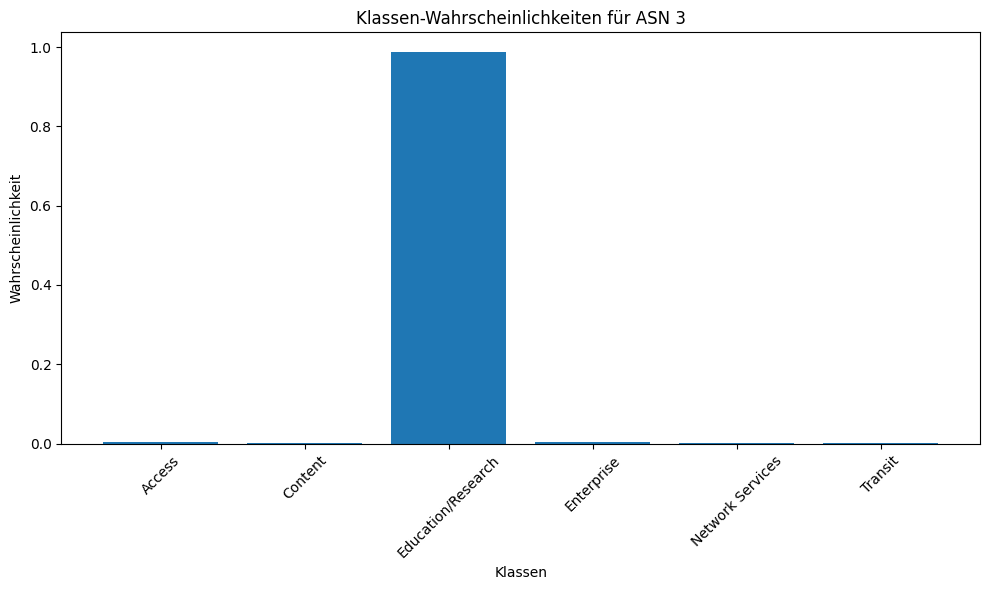

/tmp/ipykernel_1272050/3810958686.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["ratio_customer_provider"] = df_raw["asnDegree_customer"] / (df_raw["asnDegree_provider"] + 1)
/tmp/ipykernel_1272050/3810958686.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["ratio_peer_provider"]     = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_provider"] + 1)
/tmp/ipykernel_1272050/3810958686.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

(1, 74, 6)

SHAP-Werte für Klasse 'Access':


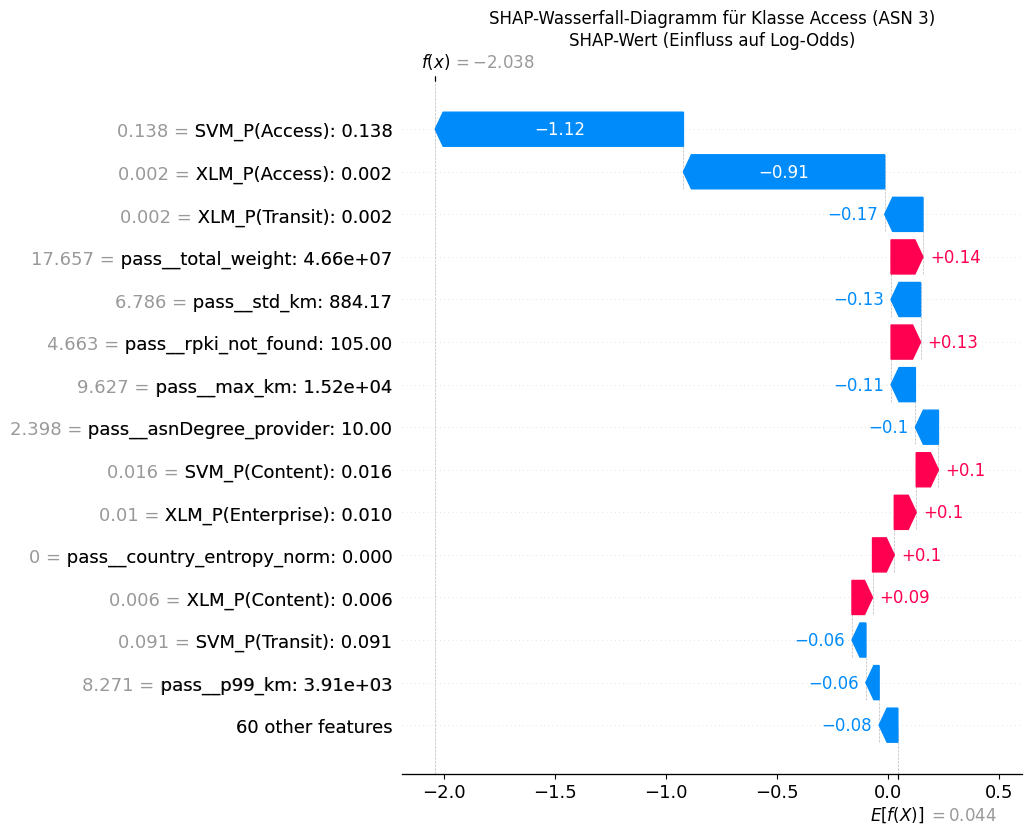


SHAP-Werte für Klasse 'Content':


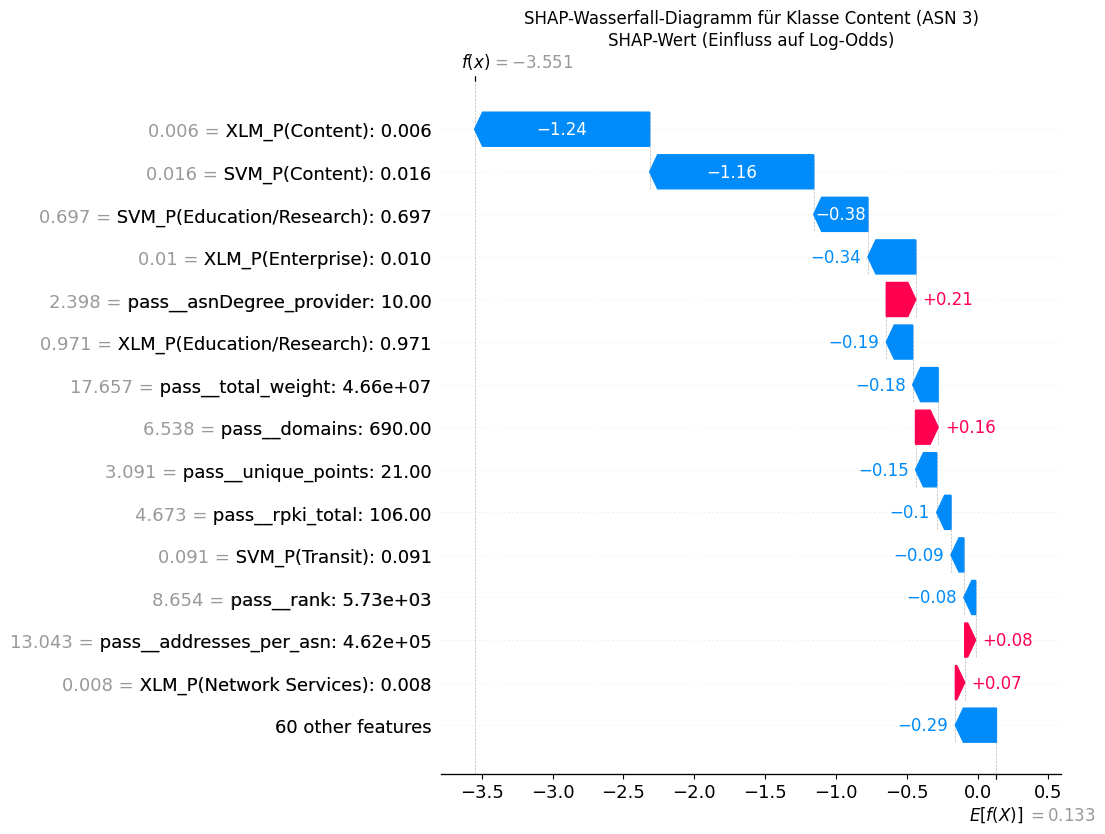


SHAP-Werte für Klasse 'Education/Research':


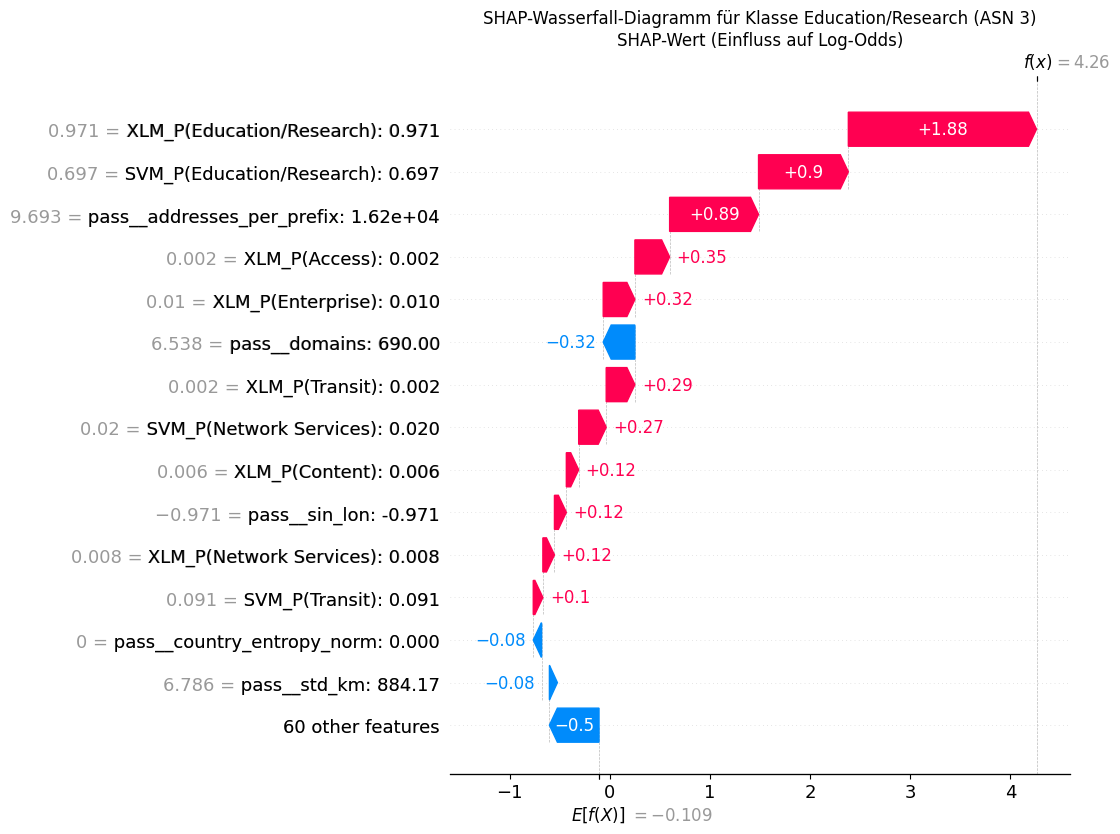


SHAP-Werte für Klasse 'Enterprise':


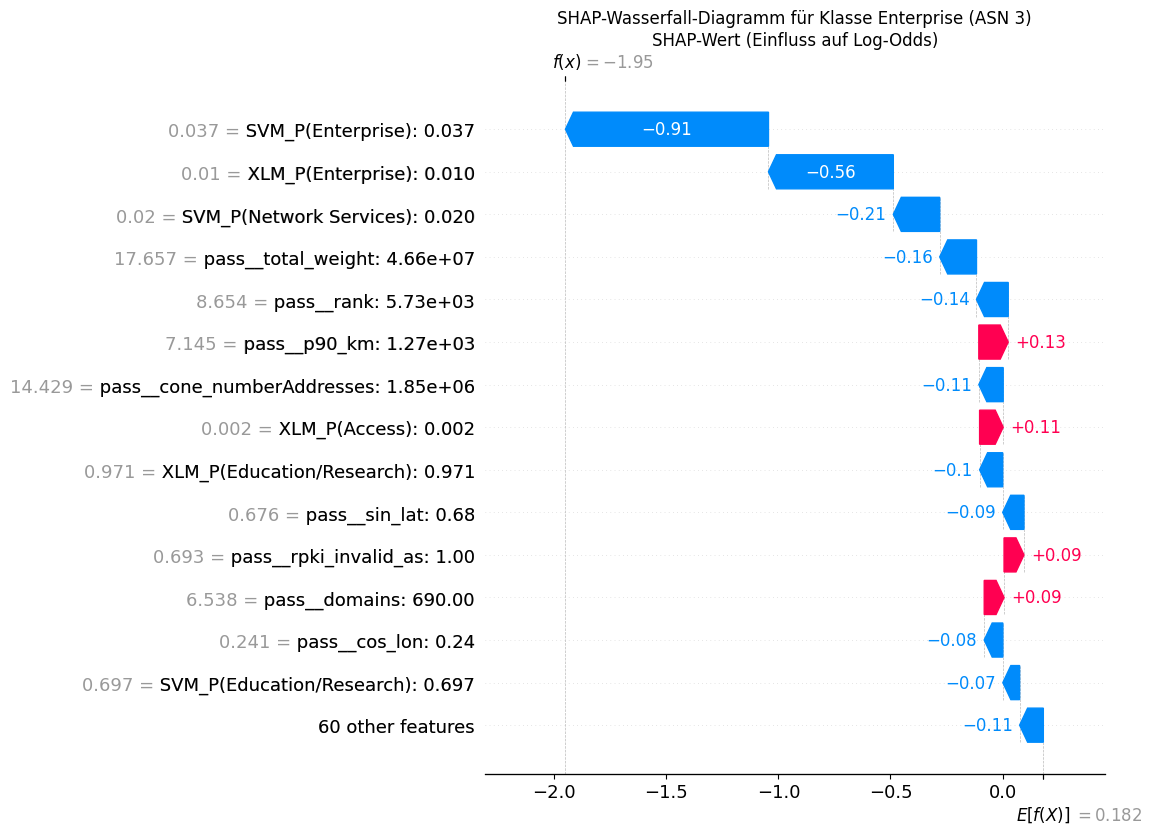


SHAP-Werte für Klasse 'Network Services':


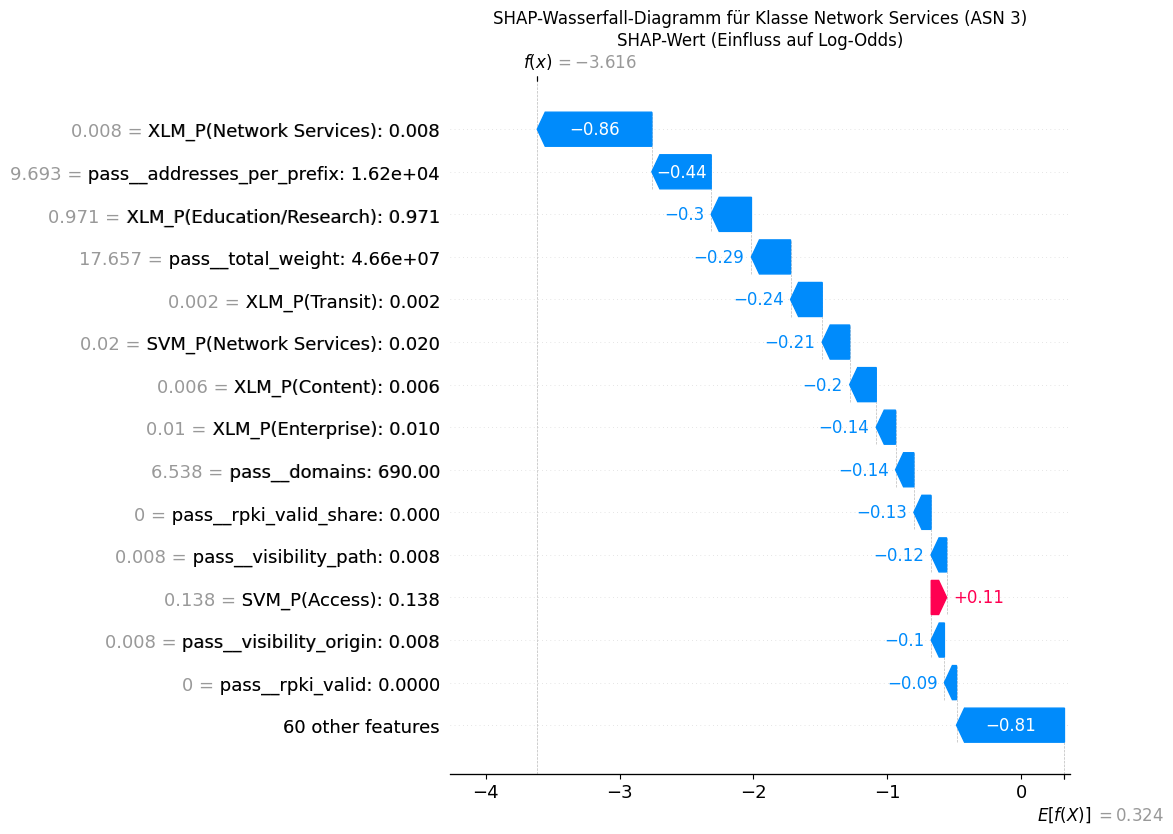


SHAP-Werte für Klasse 'Transit':


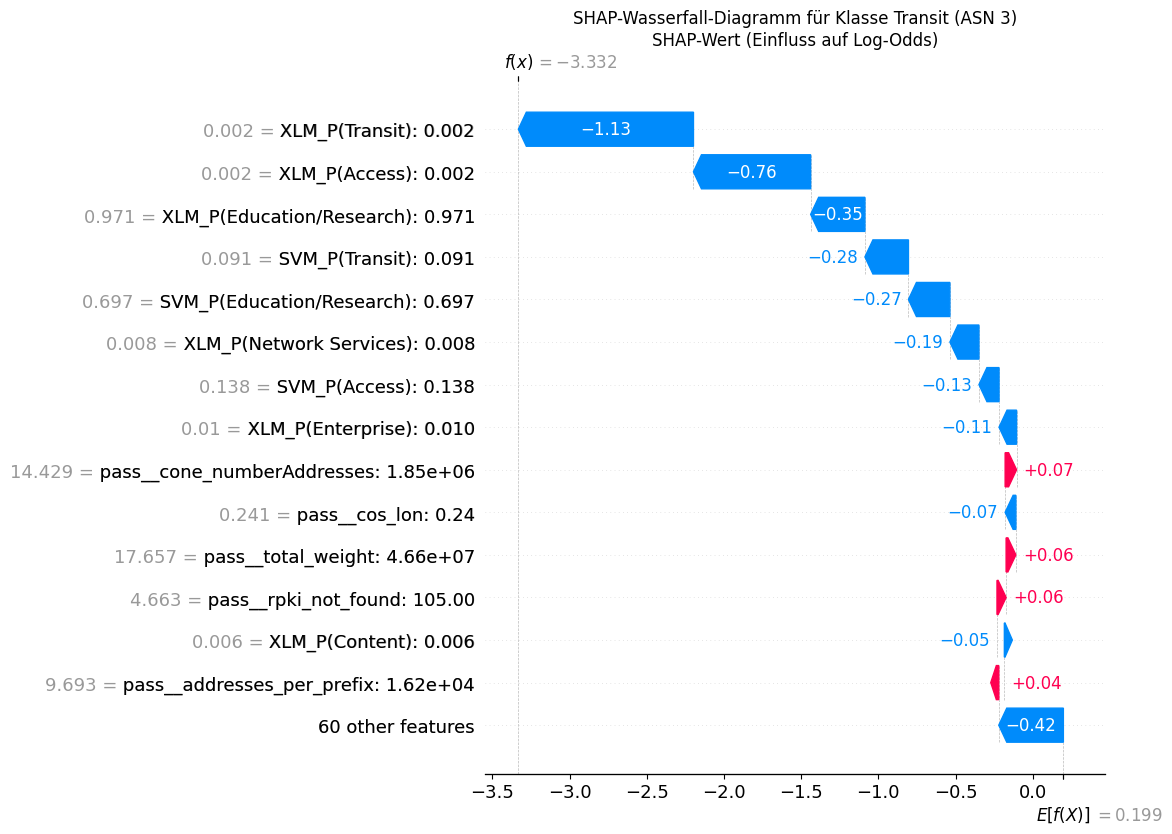

In [21]:
import matplotlib.pyplot as plt
import shap
asn = 3  # Beispiel-ASN
result_row = output_df[output_df['asn'] == asn]
og_row = bgp_names_asrank_domains_geoloc[bgp_names_asrank_domains_geoloc['asn'] == asn]
def create_inverse_feature_labels(feature_names: list, feature_values: np.ndarray) -> list:
    """
    Wendet die Inverse der log1p-Transformation an (x = exp(x') - 1)
    und erstellt neue Labels für den SHAP Plot.
    """
    new_names = []
    
    for name, value in zip(feature_names, feature_values):
        
        # 1. Inverse Transformation für log1p-Features
        if name.endswith("_log1p"):
            original_value = np.exp(value) - 1
            
            # Sonderbehandlung für die Std aus der Varianz (siehe build_numeric_frame)
            if name == "std_from_var_km_log1p":
                # Das Feature war log(1 + sqrt(var)). Inverse: (exp(x') - 1)^2
                original_value = (np.exp(value) - 1)**2
                new_name = f"var_km2: {original_value:.2f}"
            
            # Benennung: Entferne "_log1p" und formatiere den Wert
            else:
                clean_name = name.replace("_log1p", "")
                if original_value > 1000:
                    # Große Zahlen in wissenschaftlicher Notation
                    new_name = f"{clean_name}: {original_value:.2e}"
                elif original_value < 0.01:
                    # Sehr kleine Zahlen auf vier Dezimalstellen
                    new_name = f"{clean_name}: {original_value:.4f}"
                else:
                    new_name = f"{clean_name}: {original_value:.2f}"
                    
        # 2. Normale Features (Probas, Sin/Cos)
        else:
            # Einfache Formatierung
            if 'P(' in name or value < 0.01:
                new_name = f"{name}: {value:.3f}"
            elif value > 100:
                 new_name = f"{name}: {value:.1f}"
            else:
                 new_name = f"{name}: {value:.2f}"
                 
        new_names.append(new_name)
    return new_names
    
if not result_row.empty:
    print(f"Ergebnisse für ASN {asn}:")
    print(result_row.to_string(index=False))
    print("\nZusätzliche Informationen:")
    print(og_row.to_string(index=False))

    # Plot all class probabilities
    import matplotlib.pyplot as plt
    class_probs = result_row[fusion.label_names].values.flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(fusion.label_names, class_probs)
    plt.xlabel('Klassen')
    plt.ylabel('Wahrscheinlichkeit')
    plt.title(f'Klassen-Wahrscheinlichkeiten für ASN {asn}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Analyse SHAP for all Classes
    import shap
    explainer = shap.TreeExplainer(fusion.xgb)
    probs = fusion.predict_proba_from_raw_df(og_row)

    X_num, _ = build_numeric_frame(og_row)
    X_num_trans = fusion.pre_num.transform(X_num)

    # Text-Features als Wahrscheinlichkeiten
    text_probas = fusion.ens_full.predict_proba(
        *fusion._make_text_features_from_df(og_row)
    )

    # Alles zusammen
    X = np.hstack([X_num_trans, text_probas])

    feature_names = fusion._feature_names(X_num_trans, text_probas)

    shap_values = explainer(pd.DataFrame(X, columns=feature_names))

    inverse_labels = create_inverse_feature_labels(feature_names, X[0])

    print(shap_values.shape)
    for class_idx, class_name in enumerate(fusion.label_names):
        print(f"\nSHAP-Werte für Klasse '{class_name}':")
        
        # 1D SHAP-Werte dieser Klasse für diese eine Zeile
        values = shap_values.values[0, :, class_idx]
        
        # base_value richtig indizieren (Multi-Class je nach SHAP-Version)
        base_val = (
            shap_values.base_values[0, class_idx]
            if np.ndim(shap_values.base_values) == 2
            else shap_values.base_values[class_idx]
        )
        
        # Explanation mit neuen Feature-Namen
        exp = shap.Explanation(
            values=values,
            base_values=base_val,
            data=X[0],                     # transformierte Werte bleiben als data, ist ok
            feature_names=inverse_labels   # <--- hier kommen deine "entloggten" Labels rein
        )
        
        shap.plots.waterfall(exp, max_display=15, show=False)
        plt.title(f'SHAP-Wasserfall-Diagramm für Klasse {class_name} (ASN {asn})')
        plt.xlabel("SHAP-Wert (Einfluss auf Log-Odds)", fontsize=12) 
        plt.show()


Ergebnisse für ASN 3320:
 asn  predicted_class_id predicted_label  predicted_prob as-name            org-name   Access  Content  Education/Research  Enterprise  Network Services  Transit
3320                   5         Transit        0.593059    DTAG Deutsche Telekom AG 0.264313 0.047824            0.043379    0.042228          0.009198 0.593059

Zusätzliche Informationen:
 asn  seen_peers_path  visibility_path  seen_peers_origin  visibility_origin  centrality_mean  endprox_mean  nonterminal_rate  path_occurrences origin_occurrences  total_unique_paths  total_peers  rpki_valid  rpki_invalid_as  rpki_invalid_length  rpki_not_found  rpki_total  rpki_valid_share    aut  changed aut_name        org_id source            org_name country                        text  rank  asnDegree_total  asnDegree_customer  asnDegree_peer  asnDegree_provider  cone_numberAsns  cone_numberPrefixes  cone_numberAddresses    ASN  domains  center_lat  center_lon  total_weight  unique_points  country_count  mean_

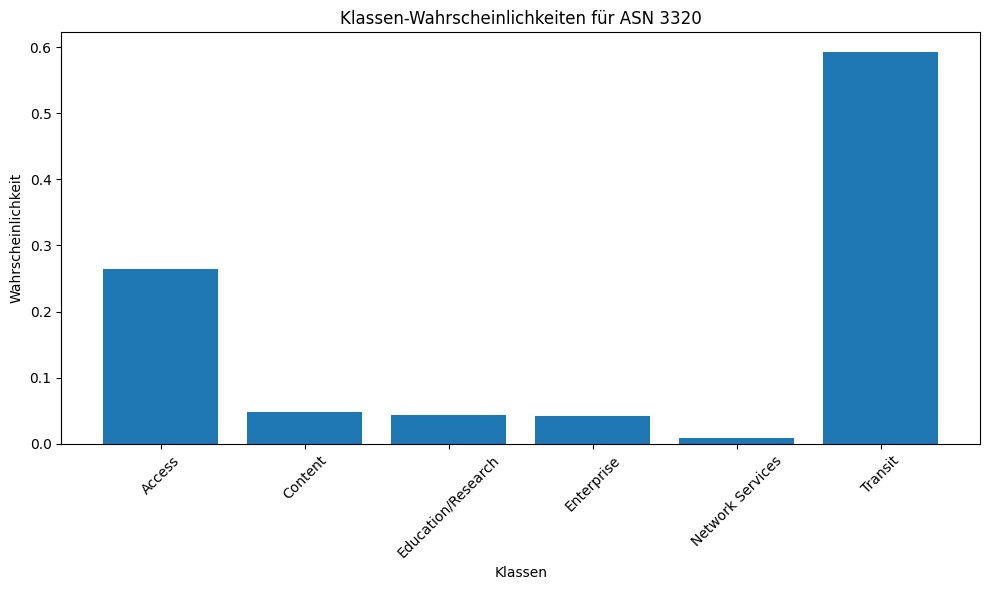

SHAP-Array-Shape: (1, 74, 6)

SHAP-Werte für Klasse 'Access':


/tmp/ipykernel_1272050/3810958686.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["ratio_customer_provider"] = df_raw["asnDegree_customer"] / (df_raw["asnDegree_provider"] + 1)
/tmp/ipykernel_1272050/3810958686.py:396: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["ratio_peer_provider"]     = df_raw["asnDegree_peer"]     / (df_raw["asnDegree_provider"] + 1)
/tmp/ipykernel_1272050/3810958686.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

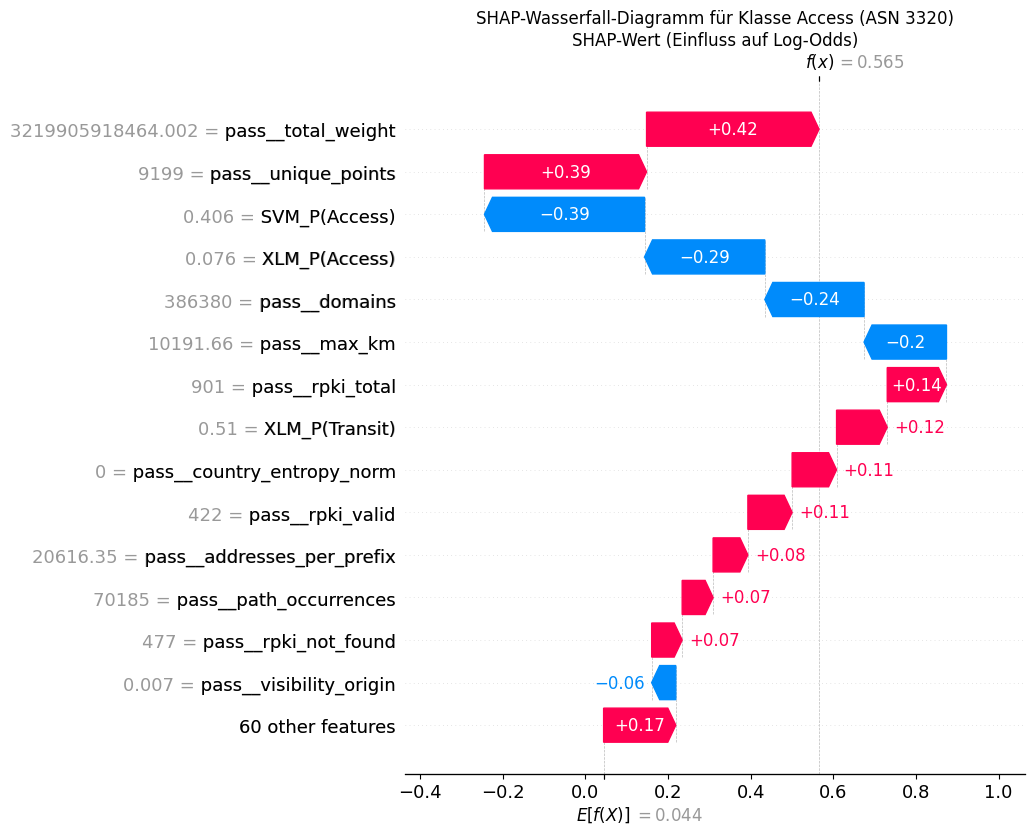


SHAP-Werte für Klasse 'Content':


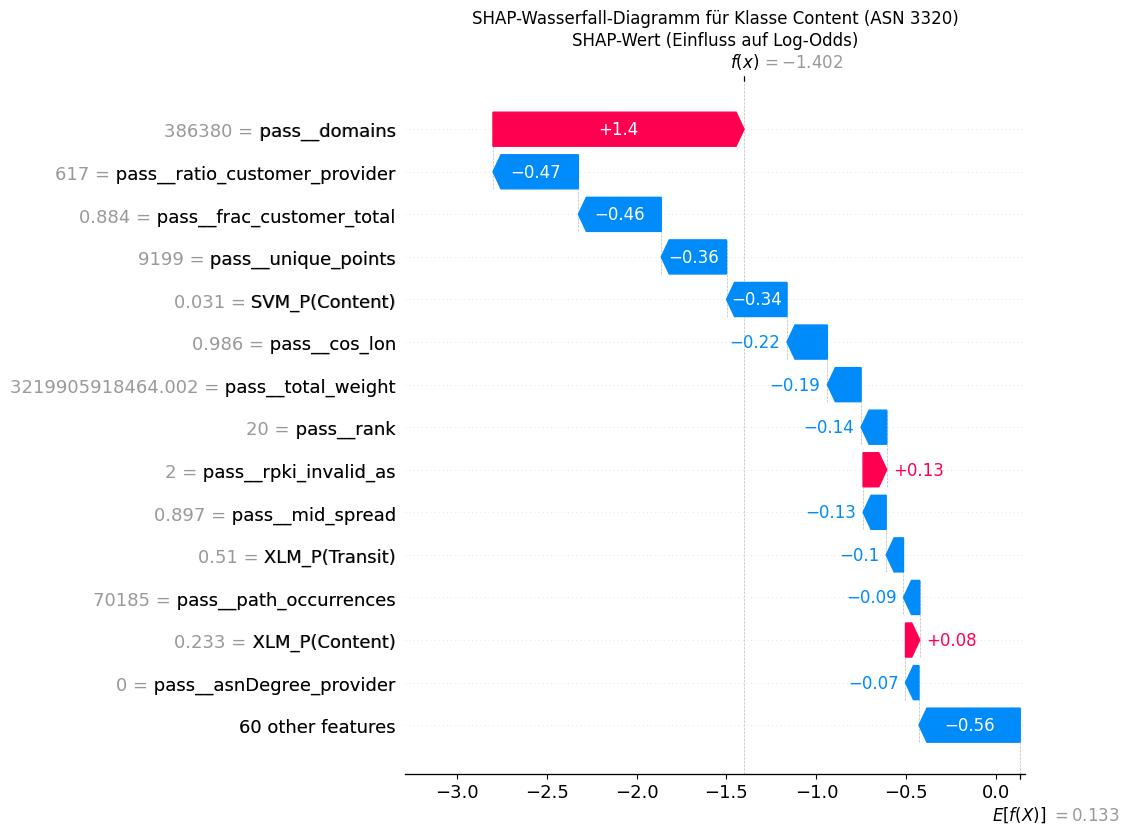


SHAP-Werte für Klasse 'Education/Research':


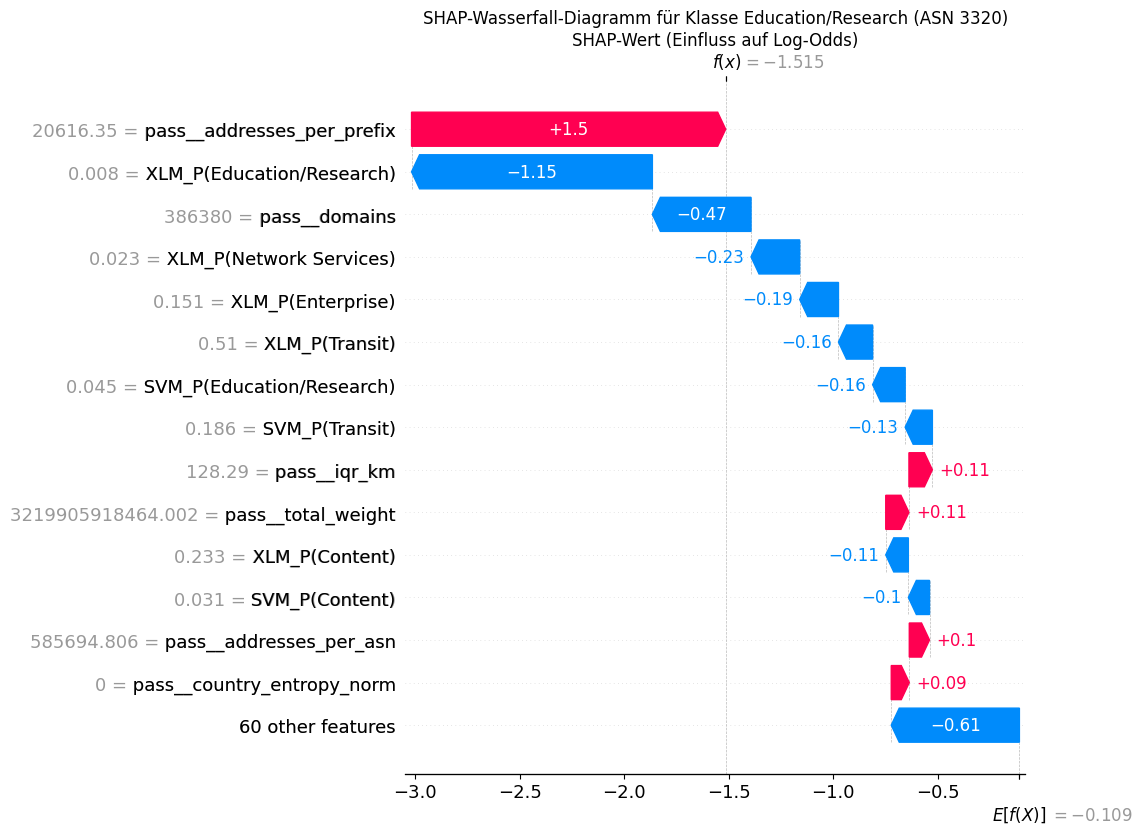


SHAP-Werte für Klasse 'Enterprise':


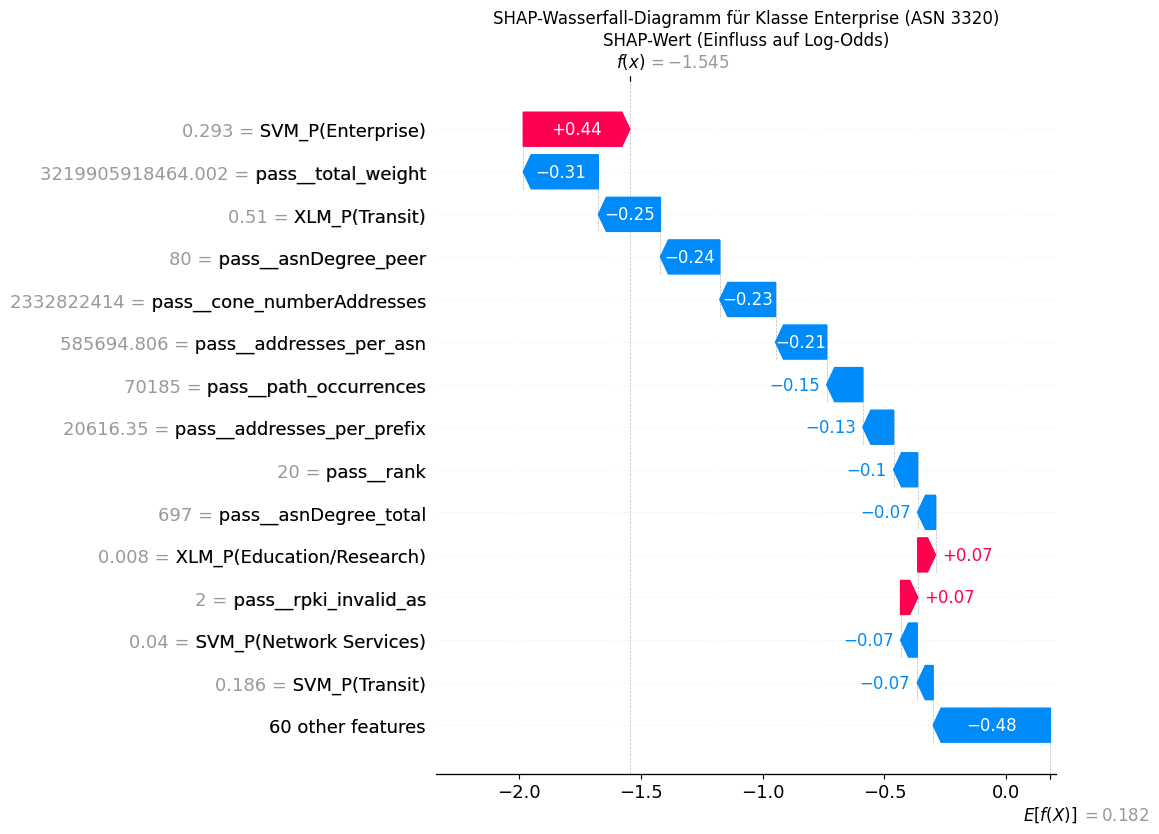


SHAP-Werte für Klasse 'Network Services':


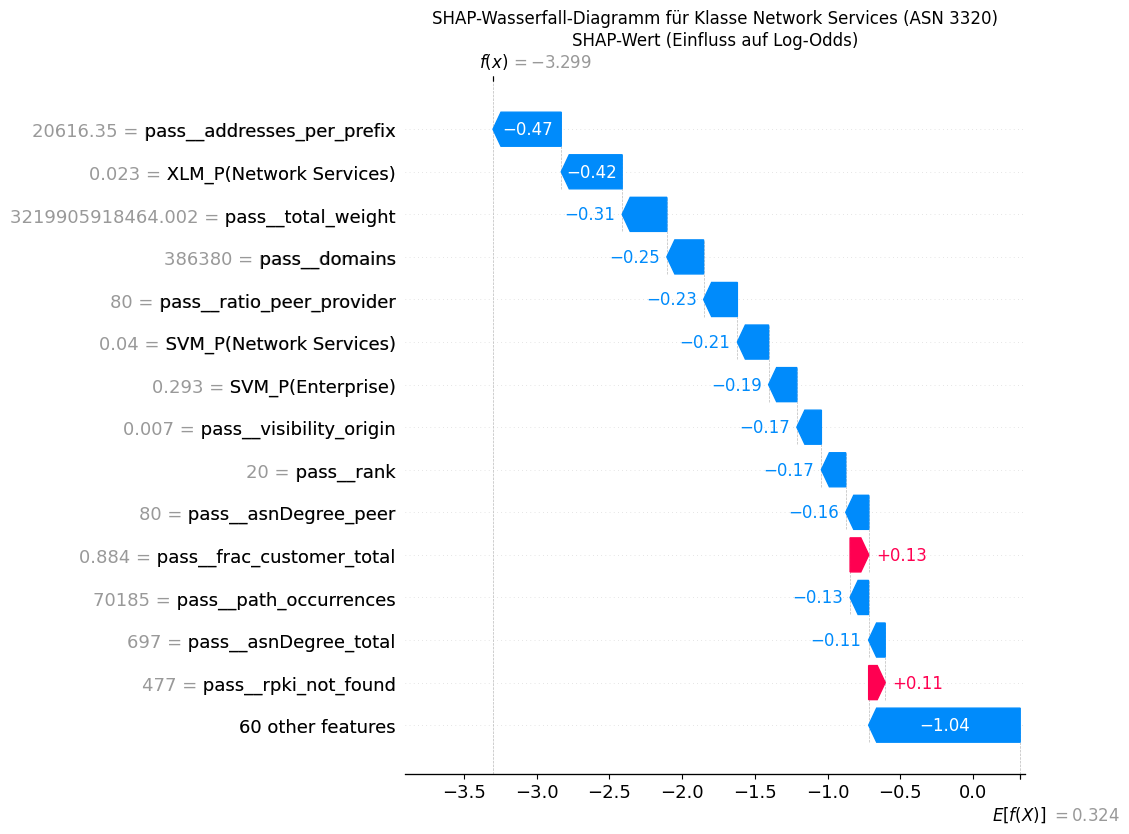


SHAP-Werte für Klasse 'Transit':


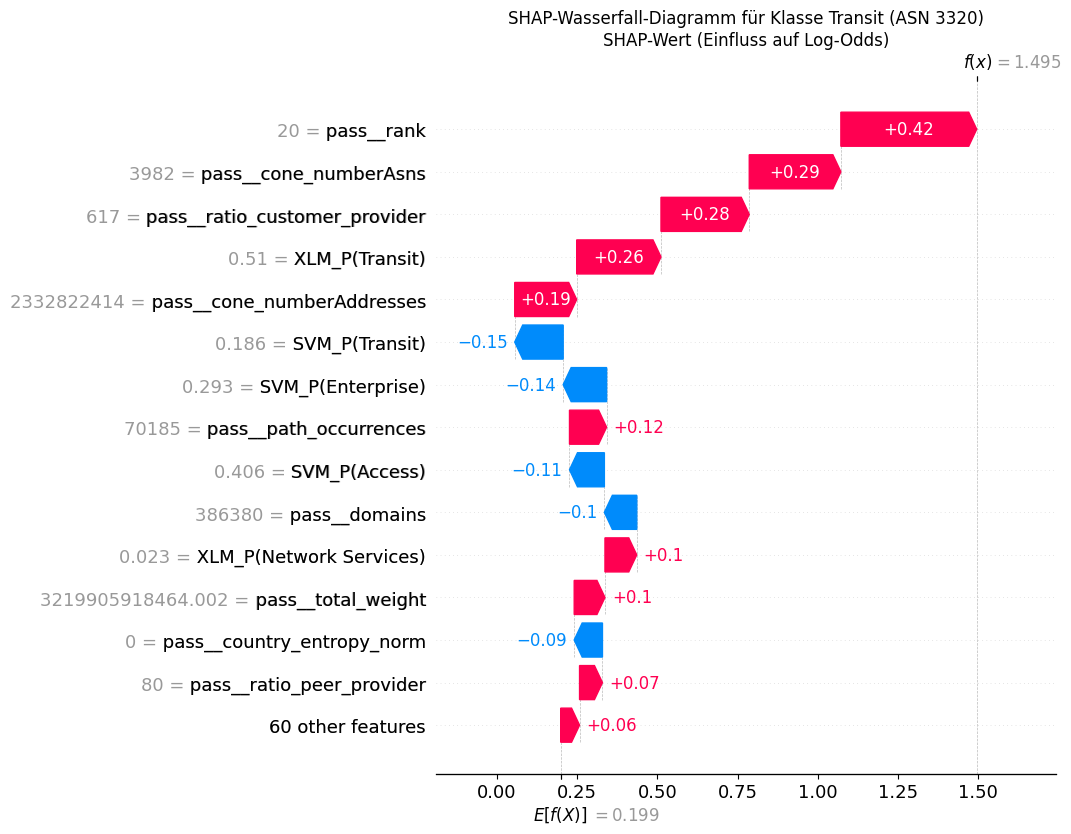

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

asn = 680  # Beispiel-ASN

result_row = output_df[output_df['asn'] == asn]
og_row = bgp_names_asrank_domains_geoloc[bgp_names_asrank_domains_geoloc['asn'] == asn]


def invert_log1p_features(feature_names: list, feature_values: np.ndarray):
    """
    Invertiert log1p-transformierte Features (x' = log(1 + x) -> x = exp(x') - 1)
    und gibt (original_values, clean_names) zurück.
    
    - Entfernt "_log1p" aus dem Namen
    - Sonderfall: std_from_var_km_log1p -> var_km2 (exp(x') - 1)^2
    """
    orig_values = []
    clean_names = []

    for name, value in zip(feature_names, feature_values):
        # log1p-transformierte Features zurückrechnen
        if name.endswith("_log1p"):
            if name == "std_from_var_km_log1p":
                # vorher: log(1 + sqrt(var)), jetzt wieder var
                original_value = np.expm1(value) ** 2
                clean_name = "var_km2"
            else:
                original_value = np.expm1(value)  # exp(value) - 1
                clean_name = name.replace("_log1p", "")
        else:
            # keine Transformation
            original_value = value
            clean_name = name

        orig_values.append(original_value)
        clean_names.append(clean_name)

    return np.array(orig_values), clean_names


if not result_row.empty and not og_row.empty:
    print(f"Ergebnisse für ASN {asn}:")
    print(result_row.to_string(index=False))
    print("\nZusätzliche Informationen:")
    print(og_row.to_string(index=False))

    # Plot aller Klassen-Wahrscheinlichkeiten
    class_probs = result_row[fusion.label_names].values.flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(fusion.label_names, class_probs)
    plt.xlabel('Klassen')
    plt.ylabel('Wahrscheinlichkeit')
    plt.title(f'Klassen-Wahrscheinlichkeiten für ASN {asn}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- SHAP-Analyse für alle Klassen ---

    explainer = shap.TreeExplainer(fusion.xgb)
    probs = fusion.predict_proba_from_raw_df(og_row)

    # Numerische Features (log1p usw.)
    X_num, _ = build_numeric_frame(og_row)
    X_num_trans = fusion.pre_num.transform(X_num)

    # Text-Features als Wahrscheinlichkeiten
    text_probas = fusion.ens_full.predict_proba(
        *fusion._make_text_features_from_df(og_row)
    )

    # Alles zusammen
    X = np.hstack([X_num_trans, text_probas])
    feature_names = fusion._feature_names(X_num_trans, text_probas)

    # SHAP-Werte berechnen
    shap_values = explainer(pd.DataFrame(X, columns=feature_names))

    # Werte + Namen in Originalskala für diesen einen Datenpunkt
    orig_data, clean_names = invert_log1p_features(feature_names, X[0])

    print("SHAP-Array-Shape:", shap_values.values.shape)

    for class_idx, class_name in enumerate(fusion.label_names):
        print(f"\nSHAP-Werte für Klasse '{class_name}':")

        # 1D SHAP-Werte dieser Klasse für diese eine Zeile
        values = shap_values.values[0, :, class_idx]

        # base_value korrekt indizieren (Multi-Class)
        base_val = (
            shap_values.base_values[0, class_idx]
            if np.ndim(shap_values.base_values) == 2
            else shap_values.base_values[class_idx]
        )

        # Explanation mit entloggten Werten und bereinigten Namen
        exp = shap.Explanation(
            values=values,
            base_values=base_val,
            data=orig_data,        # entloggte Werte
            feature_names=clean_names  # Namen ohne _log1p etc.
        )

        shap.plots.waterfall(exp, max_display=15, show=False)
        plt.title(f'SHAP-Wasserfall-Diagramm für Klasse {class_name} (ASN {asn})')
        plt.xlabel("SHAP-Wert (Einfluss auf Log-Odds)", fontsize=12)
        plt.show()
else:
    print(f"Kein Eintrag für ASN {asn} gefunden.")
